<a href="https://colab.research.google.com/github/01PrathamS/PyTorch_Exercises/blob/main/03_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
from torch import nn 

import torchvision 
from torchvision import datasets 
from torchvision.transforms import ToTensor 

import matplotlib.pyplot as plt 

In [3]:
train_data = datasets.FashionMNIST(
    root = 'data',
    train = True, 
    download = True, 
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False, 
    download = True, 
    transform = ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 19281377.90it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 354793.44it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6105794.83it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5072181.58it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [8]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

In [9]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [10]:
class_names = train_data.classes 
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

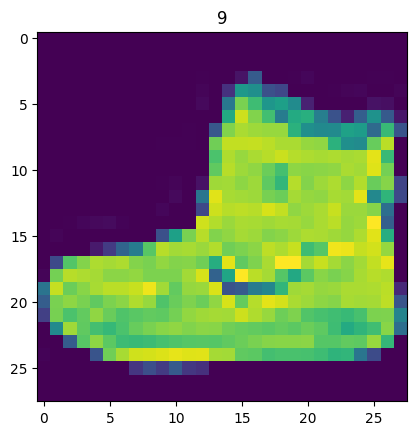

In [11]:
import matplotlib.pyplot as plt 

image, label = train_data[0] 
plt.imshow(image.squeeze()) 
plt.title(label);

Text(0.5, 1.0, 'Ankle boot')

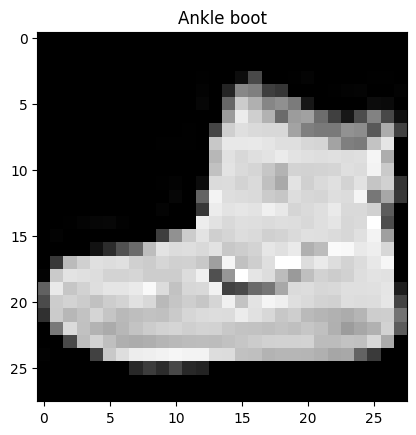

In [12]:
plt.imshow(image.squeeze(), cmap='gray') 
plt.title(class_names[label])

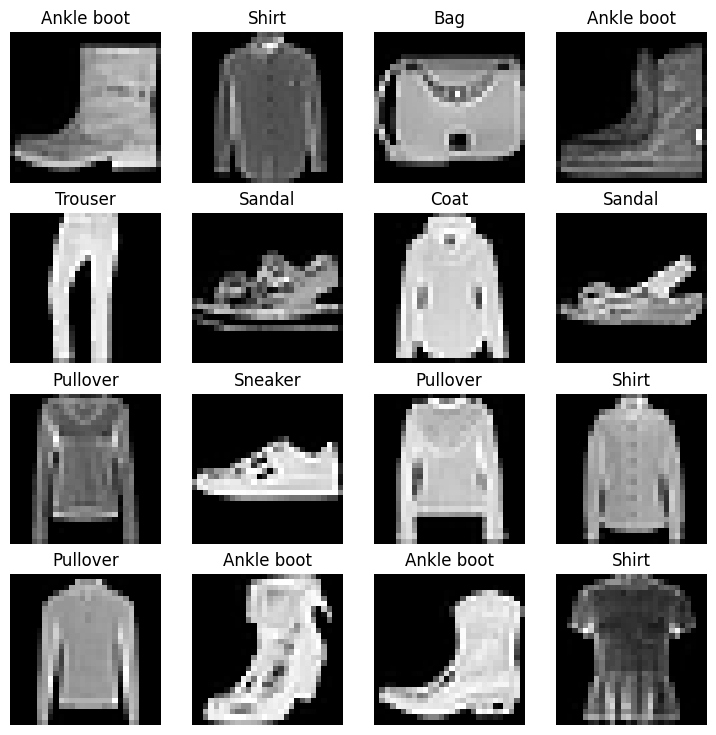

In [14]:
torch.manual_seed(42) 
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4 

for i in range(1, rows * cols + 1):

  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx] 
  fig.add_subplot(rows, cols, i) 
  plt.imshow(img.squeeze(), cmap='gray') 
  plt.title(class_names[label]) 
  plt.axis(False);


In [15]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32 

train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False)

In [21]:
from torch import nn 

class FashionMNIST_V0(nn.Module):

  def __init__(self, input_shape: int, 
               hidden_units: int, 
               output_shape: int):
    super().__init__() 
    self.layer_stack = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=input_shape, 
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units, 
                  out_features=output_shape)
    )
    
  def forward(self, x):
    return self.layer_stack(x)

In [22]:
torch.manual_seed(42) 

model_0 = FashionMNIST_V0(input_shape=784, 
                          hidden_units=10, 
                          output_shape=len(class_names)) 

model_0

FashionMNIST_V0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [23]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [25]:
from helper_functions import accuracy_fn 

loss_fn = nn.CrossEntropyLoss() 

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [26]:
from timeit import default_timer as timer 

def print_train_time(start: float, 
                     end: float, 
                     device: torch.device=None): 

    total_time = end - start 
    print(f'Train time on {device}: {total_time:3f} seconds') 
    return total_time


## Train and Test loop

In [29]:
from tqdm.auto import tqdm 

torch.manual_seed(42) 
train_time_start_on_cpu = timer() 

epochs = 3 

for epoch in tqdm(range(epochs)): 
  print(f'Epoch: {epoch}\n-------') 
  
  train_loss = 0 

  for batch, (X, y) in enumerate(train_dataloader):

    model_0.train() 
    
    y_pred = model_0(X) 
    
    loss = loss_fn(y_pred, y) 
    train_loss += loss 

    optimizer.zero_grad()

    loss.backward()
    
    optimizer.step() 
    
    if batch % 400 == 0: 
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")


  train_loss /= len(train_dataloader) 
  
  test_loss, test_acc = 0, 0 
  model_0.eval() 
  
  with torch.inference_mode():

    for X, y in test_dataloader: 

      test_pred = model_0(X) 
      
      test_loss += loss_fn(test_pred, y) 
      
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) 
      
    test_loss /= len(test_dataloader) 
    
    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end_on_cpu = timer() 

total_train_time_model_0  = print_train_time(start = train_time_start_on_cpu, 
                                  end = train_time_end_on_cpu, 
                                  device = str(next(model_0.parameters()).device))







  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.43619 | Test loss: 0.46169, Test acc: 83.81%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.43117 | Test loss: 0.46258, Test acc: 84.00%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.42613 | Test loss: 0.46444, Test acc: 83.93%

Train time on cpu: 40.995246 seconds


## 4. Make Predictions and get Model 0 results

In [32]:
torch.manual_seed(42) 

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn): 

    loss, acc = 0, 0 
    model.eval() 
    
    with torch.inference_mode():

      for X, y in data_loader: 

        y_pred = model(X) 
        
        loss += loss_fn(y_pred, y)
        acc += accuracy_fn(y_true = y, 
                           y_pred = y_pred.argmax(dim=1))
        
      loss /= len(data_loader) 
      acc /= len(data_loader) 
        
    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(), 
            'model_acc': acc}

In [33]:
model_0_results = eval_model(model=model_0, 
                             data_loader = test_dataloader, 
                             loss_fn=loss_fn, 
                             accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMNIST_V0',
 'model_loss': 0.4644448161125183,
 'model_acc': 83.92571884984025}

In [34]:
import torch 
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cpu'

## Model 1: Building a better model with non-linearity

In [37]:
class FashionMNIST_V1(nn.Module):

  def __init__(self, 
               input_shape: int, 
               hidden_units: int, 
               output_shape: int):
    super().__init__() 
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, 
                  out_features=hidden_units),
        nn.ReLU(), 
        nn.Linear(in_features=hidden_units, 
                  out_features=output_shape), 
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor): 
      return self.layer_stack(x)

In [39]:
model_1 = FashionMNIST_V1(input_shape=784, 
                          hidden_units=10, 
                          output_shape=len(class_names)) 


In [40]:
from helper_functions import accuracy_fn 

loss_fn = nn.CrossEntropyLoss() 

optimizer = torch.optim.SGD(params=model_1.parameters(), 
                            lr=0.1)

In [42]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               accuracy_fn, 
               device: torch.device=device):

  train_loss, train_acc = 0, 0 

  model.to(device) 
  
  for batch, (X,y) in enumerate(data_loader):

    X, y  = X.to(device), y.to(device) 
    
    y_pred = model(X) 
    
    loss = loss_fn(y_pred, y) 
    train_loss += loss 
    train_acc += accuracy_fn(y_true=y, 
                             y_pred = y_pred.argmax(dim=1)) 
    
    optimizer.zero_grad() 
    
    loss.backward() 
    
    optimizer.step() 
    
  train_loss /= len(data_loader) 
  train_acc /= len(data_loader) 
  
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader, 
              model: torch.nn.Module, 
              loss_fn: torch.nn.Module, 
              accuracy_fn, 
              device: torch.device = device): 


  test_loss, test_acc = 0, 0 
  model.to(device) 
  
  model.eval() 
  
  with torch.inference_mode():

    for X, y in data_loader: 

      X, y = X.to(device), y.to(device) 
      
      test_pred = model(X) 
      
      test_loss += loss_fn(test_pred, y) 
      test_acc += accuracy_fn(y_true=y, 
                              y_pred=test_pred.argmax(dim=1)) 
      
    test_loss /= len(data_loader) 
    test_acc /= len(data_loader) 
    
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [43]:
torch.manual_seed(42) 

from timeit import default_timer as timer 
train_time_start_on_gpu = timer() 

epochs = 3 
for epoch in tqdm(range(epochs)): 

  print(f'Epoch: {epoch}\n-----------') 
  
  train_step(data_loader = train_dataloader, 
             model=model_1, 
             loss_fn = loss_fn, 
             optimizer=optimizer, 
             accuracy_fn=accuracy_fn) 
  
  test_step(data_loader = test_dataloader, 
            model = model_1, 
            loss_fn = loss_fn, 
            accuracy_fn = accuracy_fn) 
  
train_time_end_on_gpu = timer() 
total_train_time_model_1 = print_train_time(start = train_time_start_on_gpu, 
                                            end = train_time_end_on_gpu, 
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 1.12767 | Train accuracy: 61.22%
Test loss: 0.91791 | Test accuracy: 68.80%

Epoch: 1
-----------
Train loss: 0.78775 | Train accuracy: 72.83%
Test loss: 0.73556 | Test accuracy: 73.72%

Epoch: 2
-----------
Train loss: 0.68138 | Train accuracy: 75.29%
Test loss: 0.71250 | Test accuracy: 74.58%

Train time on cpu: 39.958019 seconds


In [44]:
torch.manual_seed(42) 

model_1_results = eval_model(model=model_1, 
                             data_loader = test_dataloader, 
                             loss_fn = loss_fn, 
                             accuracy_fn = accuracy_fn) 
model_1_results

{'model_name': 'FashionMNIST_V1',
 'model_loss': 0.7125033736228943,
 'model_acc': 74.58067092651757}

## Model 2: Building a Convolutional Neural Network(CNN)

In [47]:
class FashionMNIST_V2(nn.Module):

  def __init__(self, input_shape: int, 
               hidden_units: int,
               output_shape: int):
    super().__init__() 
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units, 
                  kernel_size=3, 
                  stride=1, 
                  padding=1),
        nn.ReLU(), 
        nn.Conv2d(in_channels=hidden_units, 
                  out_channels=hidden_units, 
                  kernel_size=3, 
                  stride=1, 
                  padding=1),
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, 
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1), 
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1), 
        nn.ReLU(), 
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*7*7, 
                  out_features=output_shape)
    )
    
  def forward(self, x: torch.Tensor):

    x = self.block_1(x) 

    x = self.block_2(x) 

    x = self.classifier(x) 

    return x 

torch.manual_seed(42) 
model_2 = FashionMNIST_V2(input_shape=1, 
                               hidden_units=10, 
                               output_shape=len(class_names))
model_2 
    

FashionMNIST_V2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## What we've done in common practice in machine learning, 
## Find a model architecture somewhere and replicate it with code.

In [49]:
loss_fn = nn.CrossEntropyLoss() 

optimizer = torch.optim.SGD(params=model_2.parameters(), 
                            lr=0.1)

torch.manual_seed(42) 

from timeit import default_timer as timer 

train_time_start_model_2 = timer() 

epochs = 3 
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n------') 
  
  train_step(data_loader=train_dataloader, 
             model = model_2, 
             loss_fn = loss_fn, 
             optimizer = optimizer, 
             accuracy_fn = accuracy_fn, 
             device = device) 
  
  test_step(data_loader = test_dataloader, 
            model = model_2, 
            loss_fn = loss_fn, 
             
            accuracy_fn = accuracy_fn, 
            device = device
            )
  
train_time_end_model_2 = timer() 

total_train_time_model_2 = print_train_time(start = train_time_start_model_2,
                                            end = train_time_end_model_2, 
                                            device = device 
                                            )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.36475 | Train accuracy: 86.92%
Test loss: 0.35552 | Test accuracy: 87.03%

Epoch: 1
------
Train loss: 0.32651 | Train accuracy: 88.19%
Test loss: 0.33109 | Test accuracy: 87.47%

Epoch: 2
------
Train loss: 0.30717 | Train accuracy: 88.88%
Test loss: 0.31826 | Test accuracy: 88.52%

Train time on cpu: 180.629536 seconds


## Every Layer in a neural network is trying to compress data from 
# higher dimensional space to lower dimensional space

In [50]:
model_2_results = eval_model(
    model = model_2, 
    data_loader = test_dataloader, 
    loss_fn = loss_fn, 
    accuracy_fn = accuracy_fn

)
model_2_results

{'model_name': 'FashionMNIST_V2',
 'model_loss': 0.3182623088359833,
 'model_acc': 88.51837060702876}

In [51]:
import pandas as pd 

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNIST_V0,0.464445,83.925719
1,FashionMNIST_V1,0.712503,74.580671
2,FashionMNIST_V2,0.318262,88.518371


In [52]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNIST_V0,0.464445,83.925719,40.995246
1,FashionMNIST_V1,0.712503,74.580671,39.958019
2,FashionMNIST_V2,0.318262,88.518371,180.629536


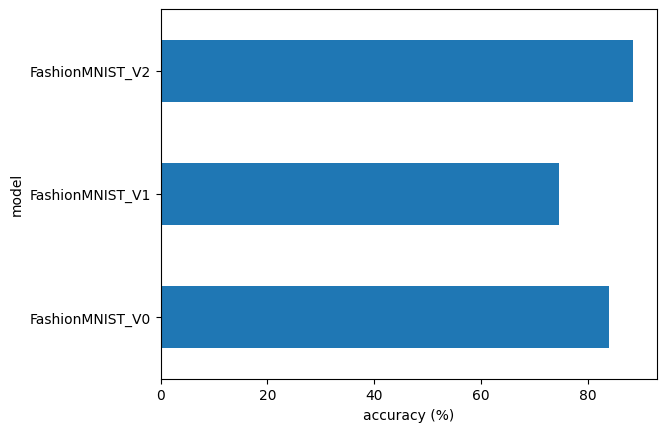

In [53]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

In [54]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [55]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.5 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [56]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


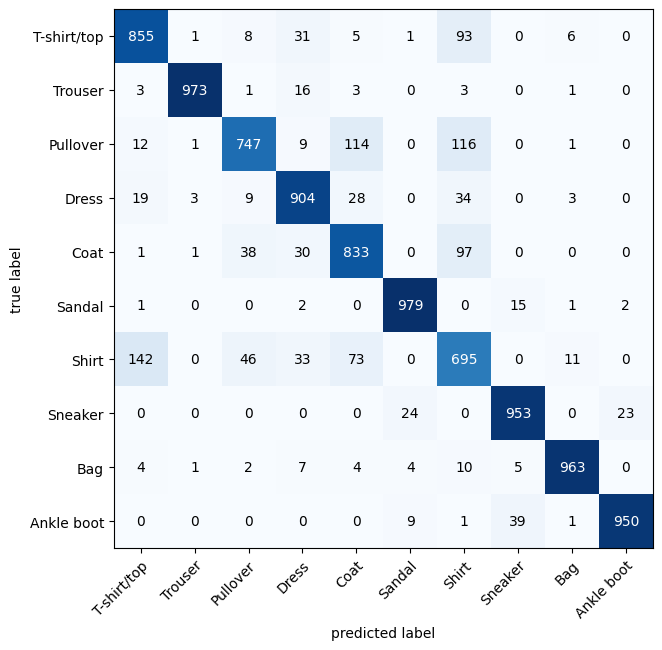

In [57]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);